# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

# Converting column dtypes

In [3]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year
#df.info()

In [4]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('int')

In [5]:
# creating new columns for renovation features bed vs bath
df['bath_bed'] = df['bathrooms']/df['bedrooms']
df['bed_bath'] = df['bedrooms']/df['bathrooms']
df['bed_bath_sum'] = df['bedrooms']+df['bathrooms']

In [6]:
# lambda function to extract the first character of each object and convert it to an int.
extract_num = lambda x: int(x[:2])

# Apply the lambda function
df['grade'] = df['grade'].apply(extract_num)

In [7]:
condish = {'Poor': 1,'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
df.condition = [condish[item] for item in df.condition]

In [8]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

# Filtering out rows not in King County

In [9]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

#### URL for King County Coordinate info
[King County Coordinates and Zipcode info](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [10]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

#### (Keeping the following code for view, heat_source, and sewer_system until we get a better idea of what we want to do with them but for now it seems like they have little correlation with price)

In [11]:
#NOT SURE WHAT TO DO WITH VIEW. TAKES AWAY 90% OF DATA WHEN TAKING AWAY 'NONE'

#views = {'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}
#df_copy2 = df_copy2.replace(to_replace='NONE', value=np.nan).dropna()
#df_king.view = [views[item] for item in df_king.view]

In [12]:
#one-hot encoding heat source
#heat = {'heat_source': ['Gas', 'Electricity', 'Oil', 'Gas/Solar',
#                        'Electricity/Solar', 'Other', 'Oil/Solar']}

# One-Hot Encoding 'heat_source' column
#df_encoded_heat = pd.get_dummies(df, columns=['heat_source'])

#df_encoded_heat.info()

In [13]:
#one-hot encoding heat source
#sewer = {'sewer_system': ['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED']}

# One-Hot Encoding 'heat_source' column
#df_encoded_sew = pd.get_dummies(df, columns=['heat_source'])

#df_encoded_heat.info()

# Dropping Null, Duplicate, and Unecessary Columns

In [14]:
df_king.drop(['id', 'address'], axis=1, inplace=True)
#df_king.info()

In [15]:
# note, may want to revisit these values as features 

# dropping lat, long and view, sqft_lot, sewer_system, heat_source, date for 
#easier view in heatmap since there is little correlation with price
df_king.drop(['lat', 'long', 'view', 'heat_source', 'sewer_system', 'sqft_lot', 'date'], axis=1, inplace=True)

In [16]:
df_king.drop_duplicates(inplace=True)
#df_king.info()

In [17]:
df_king.dropna(inplace=True)
#df_king.info()

In [18]:
df_king.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.616893
grade            0.577923
sqft_above       0.545783
bathrooms        0.488810
bed_bath_sum     0.431955
sqft_patio       0.317908
bedrooms         0.290522
bath_bed         0.276884
sqft_garage      0.266986
sqft_basement    0.247022
waterfront       0.237989
floors           0.203390
yr_built         0.107105
yr_renovated     0.085525
greenbelt        0.068856
nuisance        -0.005732
condition       -0.012158
zipcode         -0.104040
bed_bath        -0.233604
Name: price, dtype: float64

# Removing outliers from continuous data fields, ending with pricing

### (only real outliers contained in price. Rest of the entries have outliers but price holds the most and after removing all outliers we are left with a dataframe of nearly 26k entries. 

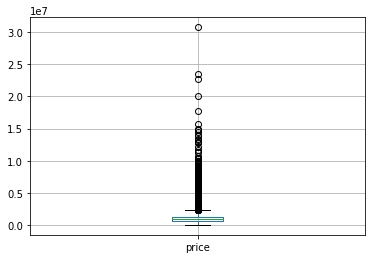

In [19]:
df_king.boxplot(column=['price'])

plt.show()

In [20]:
#df_king_price =df_king[df_king['price'] <= 1882000]
#df_king_price.info()

In [21]:
df_king1 = df_king[df_king['sqft_living'] <= 9000]
#df_king1.info()

In [22]:
df_king2 = df_king1[df_king1['sqft_above'] <= 9000]
#df_king2.info()

In [23]:
df_king3 = df_king2[df_king2['sqft_patio'] <= 2000]
#df_king3.info()

In [24]:
df_king4 = df_king3[df_king3['sqft_garage'] <= 2000]
#df_king4.info()

In [25]:
df_king5 = df_king4[df_king4['sqft_basement'] <= 3000]
#df_king5.info()

In [26]:
df_king_county = df_king5[df_king5['price'] <= 1882000]
df_king_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25956 entries, 0 to 30154
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          25956 non-null  float64
 1   bedrooms       25956 non-null  int64  
 2   bathrooms      25956 non-null  float64
 3   sqft_living    25956 non-null  int64  
 4   floors         25956 non-null  float64
 5   waterfront     25956 non-null  int64  
 6   greenbelt      25956 non-null  int64  
 7   nuisance       25956 non-null  int64  
 8   condition      25956 non-null  int64  
 9   grade          25956 non-null  int64  
 10  sqft_above     25956 non-null  int64  
 11  sqft_basement  25956 non-null  int64  
 12  sqft_garage    25956 non-null  int64  
 13  sqft_patio     25956 non-null  int64  
 14  yr_built       25956 non-null  int64  
 15  yr_renovated   25956 non-null  int64  
 16  zipcode        25956 non-null  int32  
 17  bath_bed       25956 non-null  float64
 18  bed_ba

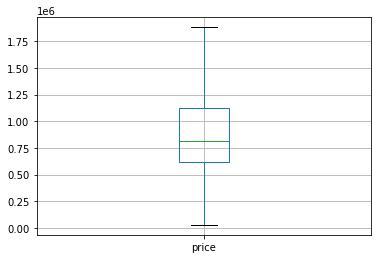

In [27]:
df_king_county.boxplot(column=['price'])

plt.show()

# 3. Looking at heatmap of new dataset 

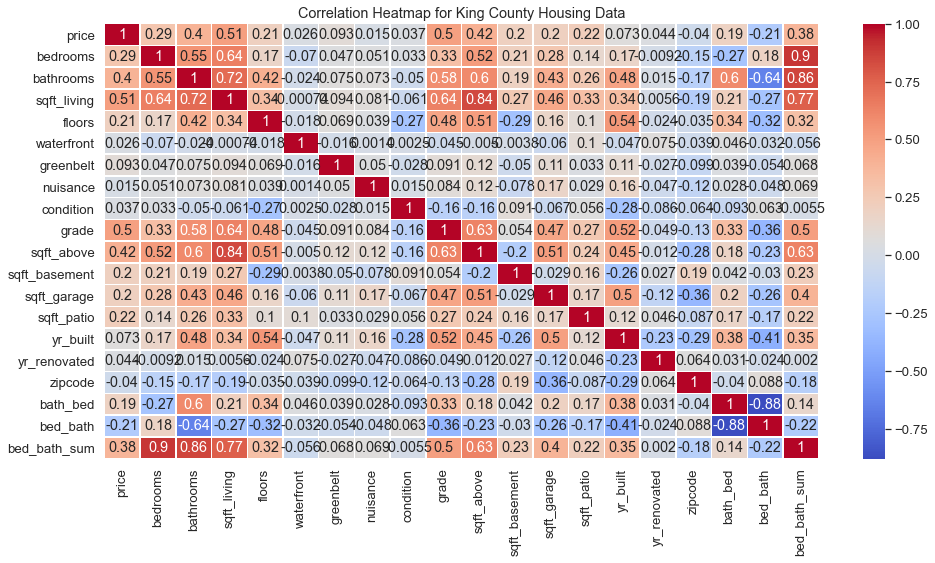

In [28]:
corr_matrix = df_king_county.corr(method='pearson')

sns.set(font_scale=1.2)
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for King County Housing Data")
plt.show()

In [29]:
df_king_county.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.507430
grade            0.499389
sqft_above       0.416603
bathrooms        0.402703
bed_bath_sum     0.383949
bedrooms         0.285343
sqft_patio       0.223382
floors           0.205315
sqft_basement    0.202702
sqft_garage      0.201916
bath_bed         0.187403
greenbelt        0.092544
yr_built         0.073224
yr_renovated     0.043684
condition        0.037165
waterfront       0.025829
nuisance         0.015492
zipcode         -0.039871
bed_bath        -0.212989
Name: price, dtype: float64

# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


### Condition Column info:

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Grade Column Info:

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.